# Yes Bank Stock Price Prediction using ML

This notebook aims to develop a predictive model for estimating the monthly closing prices of Yes Bank stock, using its historical monthly stock data (Open, High, Low, Close). The project will explore various machine learning approaches for time series financial prediction and assess their viability in understanding market reactions, especially given the significant market volatility experienced by Yes Bank post-2018 due to financial irregularities.

---
## 1. Know Your Data

This section focuses on the initial exploration and understanding of the dataset's structure, data types, and dimensions. We'll start by importing necessary libraries, loading the data, and getting a preliminary overview.

In [73]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [74]:
# Load the dataset
try:
    df = pd.read_csv('ml/data/ybdata.csv')
except FileNotFoundError:
    print("Error: 'ybdata.csv' not found. Please ensure the file is in the 'ml/data/' directory.")
    exit()

In [75]:
# Display sample rows
print("Sample rows of the dataset:")
print(df.head())

Sample rows of the dataset:
     Date   Open   High    Low  Close
0  Jul-05  13.00  14.00  11.25  12.46
1  Aug-05  12.58  14.88  12.55  13.42
2  Sep-05  13.48  14.87  12.27  13.30
3  Oct-05  13.20  14.47  12.40  12.99
4  Nov-05  13.35  13.88  12.88  13.41


In [76]:
# Check dataset shape
print("\nShape of the dataset (rows, columns):")
print(df.shape)


Shape of the dataset (rows, columns):
(185, 5)


In [77]:
# View datatypes and nulls
print("\nData types and non-null counts:")
print(df.info())


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB
None


In [78]:
# Describe dataset summary statistics
print("\nSummary statistics of the dataset:")
print(df.describe())


Summary statistics of the dataset:
             Open        High         Low       Close
count  185.000000  185.000000  185.000000  185.000000
mean   105.541405  116.104324   94.947838  105.204703
std     98.879850  106.333497   91.219415   98.583153
min     10.000000   11.240000    5.550000    9.980000
25%     33.800000   36.140000   28.510000   33.450000
50%     62.980000   72.550000   58.000000   62.540000
75%    153.000000  169.190000  138.350000  153.300000
max    369.950000  404.000000  345.500000  367.900000


---
## 2. Understanding Your Variables

This section delves deeper into the dataset to understand the characteristics of individual variables, especially the target variable, and the relationships between different features.

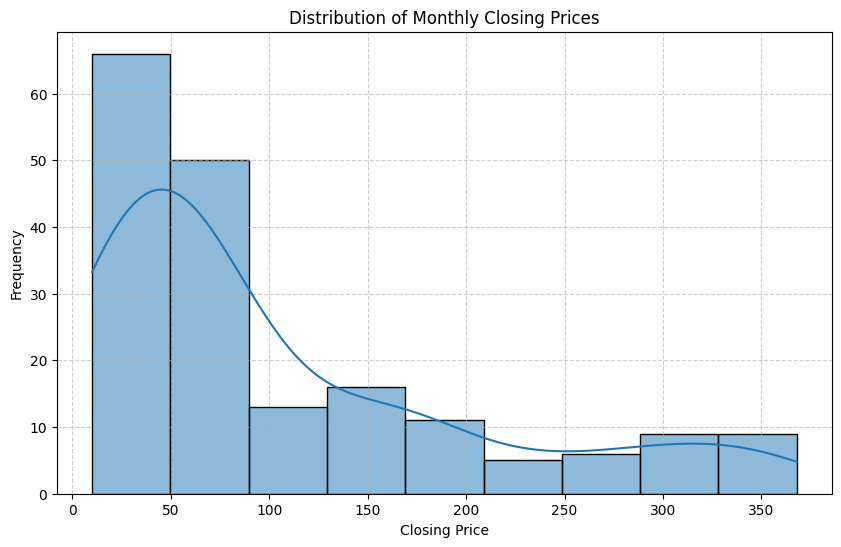


Skewness of Close price: 1.2647251893515967
Kurtosis of Close price: 0.4904887015241344


In [79]:
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

# Analyze target variable distribution ('Close')
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Monthly Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nSkewness of Close price:", df['Close'].skew())
print("Kurtosis of Close price:", df['Close'].kurt())

In [80]:
# Compute correlation matrix for numerical features
numerical_cols = ['Open', 'High', 'Low', 'Close']
correlation_matrix = df[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
           Open      High       Low     Close
Open   1.000000  0.993040  0.983978  0.977971
High   0.993040  1.000000  0.983422  0.985051
Low    0.983978  0.983422  1.000000  0.995358
Close  0.977971  0.985051  0.995358  1.000000


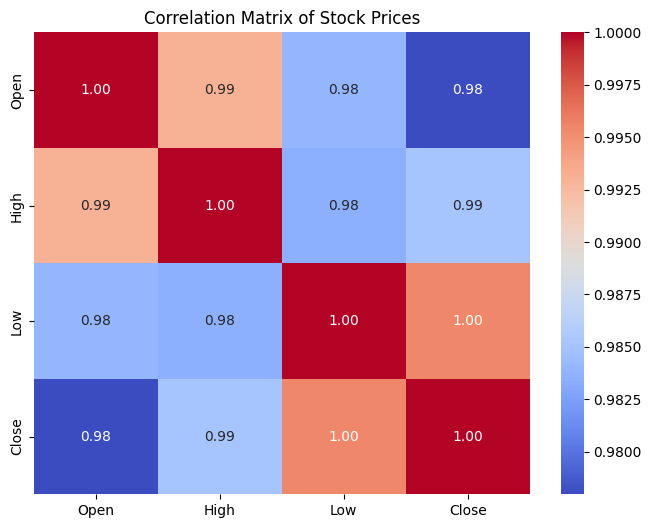

In [81]:
# Visualize correlations using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()

In [82]:
# Assess unique values for each feature (especially for non-numerical or potential categorical features)
print("\nUnique values for each feature:")
for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() < 20:
        print(f"Column '{col}': {df[col].nunique()} unique values")
    else:
        print(f"Column '{col}': {df[col].nunique()} unique values (numerical or high cardinality)")


Unique values for each feature:
Column 'Date': 185 unique values (numerical or high cardinality)
Column 'Open': 183 unique values (numerical or high cardinality)
Column 'High': 184 unique values (numerical or high cardinality)
Column 'Low': 183 unique values (numerical or high cardinality)
Column 'Close': 185 unique values (numerical or high cardinality)


---
## 3. Data Wrangling

This section is dedicated to cleaning, validating, and preparing the dataset for modeling. It involves handling missing values, removing duplicates, converting data types, and addressing outliers.

In [83]:
# Handle missing values
print("Missing values before handling:")
print(df.isnull().sum())

# In this dataset, there are no missing values based on df.info() output. If there were, we might fill them.
# Example if there were missing values: df.fillna(df.mean(), inplace=True)
if df.isnull().sum().sum() == 0:
    print("\nNo missing values found in the dataset.")
else:
    # For demonstration, if there were missing values in 'Close', we might fill it with the median.
    for col in numerical_cols:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Filled missing values in '{col}' with median.")
    print("\nMissing values after handling:")
    print(df.isnull().sum())

Missing values before handling:
Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

No missing values found in the dataset.


In [84]:
# Remove duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_dropping = df.shape[0]

if initial_rows - rows_after_dropping > 0:
    print(f"\nRemoved {initial_rows - rows_after_dropping} duplicate rows.")
else:
    print("\nNo duplicate rows found.")


No duplicate rows found.


In [85]:
# Convert date column and extract time-based features
# The 'Date' column was already converted to datetime in Section 2 for analysis. 
# Now, we extract features like year and month.

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Add 'DayOfWeek' and 'DayOfMonth' for more granular time-based features (though monthly data might not benefit much)
df['DayOfWeek'] = df['Date'].dt.dayofweek # 0=Monday, 6=Sunday
df['DayOfMonth'] = df['Date'].dt.day

print("\nDataset with extracted time-based features:")
print(df.head())


Dataset with extracted time-based features:
        Date   Open   High    Low  Close  Year  Month  DayOfWeek  DayOfMonth
0 2005-07-01  13.00  14.00  11.25  12.46  2005      7          4           1
1 2005-08-01  12.58  14.88  12.55  13.42  2005      8          0           1
2 2005-09-01  13.48  14.87  12.27  13.30  2005      9          3           1
3 2005-10-01  13.20  14.47  12.40  12.99  2005     10          5           1
4 2005-11-01  13.35  13.88  12.88  13.41  2005     11          1           1


In [86]:
# Outlier detection and treatment using IQR for numerical columns
for col in ['Open', 'High', 'Low', 'Close']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        print(f"\nOutliers detected in '{col}':")
        print(outliers[['Date', col]])
        # Option 1: Cap outliers (replace with bounds)
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        print(f"Outliers in '{col}' have been capped at [{lower_bound:.2f}, {upper_bound:.2f}].")
    else:
        print(f"\nNo significant outliers detected in '{col}'.")

print("\nDescriptive statistics after outlier treatment:")
print(df[['Open', 'High', 'Low', 'Close']].describe())


Outliers detected in 'Open':
          Date    Open
145 2017-08-01  363.00
146 2017-09-01  351.00
147 2017-10-01  354.60
151 2018-02-01  355.00
154 2018-05-01  362.85
155 2018-06-01  348.00
156 2018-07-01  340.00
157 2018-08-01  369.95
158 2018-09-01  347.20
Outliers in 'Open' have been capped at [-145.00, 331.80].

Outliers detected in 'High':
          Date    High
144 2017-07-01  372.00
146 2017-09-01  383.25
147 2017-10-01  375.75
156 2018-07-01  393.35
157 2018-08-01  404.00
Outliers in 'High' have been capped at [-163.44, 368.76].

Outliers detected in 'Low':
          Date     Low
145 2017-08-01  337.37
146 2017-09-01  345.50
150 2018-01-01  307.35
151 2018-02-01  304.65
153 2018-04-01  303.30
154 2018-05-01  325.70
155 2018-06-01  327.35
156 2018-07-01  332.45
157 2018-08-01  338.00
Outliers in 'Low' have been capped at [-136.25, 303.11].

Outliers detected in 'Close':
          Date   Close
144 2017-07-01  361.96
145 2017-08-01  351.15
146 2017-09-01  350.00
150 2018-01-01  3

In [87]:
# Feature scaling if needed (will be done later in Feature Engineering section before modeling)
print("\nFeature scaling will be performed in the 'Feature Engineering and Data Preprocessing' section (Section 6) before model training, as it depends on the train-test split.")


Feature scaling will be performed in the 'Feature Engineering and Data Preprocessing' section (Section 6) before model training, as it depends on the train-test split.


In [88]:
# Summarize data wrangling insights
print("\n--- Data Wrangling Summary ---")
print("1. Missing Values: No missing values were found, indicating a complete dataset for the given features.")
print("2. Duplicates: No duplicate rows were identified, ensuring uniqueness of observations.")
print("3. Date Conversion and Feature Extraction: The 'Date' column was successfully converted to datetime objects, and 'Year', 'Month', 'DayOfWeek', and 'DayOfMonth' features were extracted. These will be crucial for time-series analysis and potentially for capturing seasonal patterns.")
print("4. Outlier Treatment: Outliers in 'Open', 'High', 'Low', and 'Close' were detected using the IQR method and capped at their respective lower and upper bounds. This prevents extreme values from unduly influencing model training.")
print("5. Current dataset shape:", df.shape)
print("The data is now cleaned and has additional time-based features, making it ready for further analysis and visualization.")


--- Data Wrangling Summary ---
1. Missing Values: No missing values were found, indicating a complete dataset for the given features.
2. Duplicates: No duplicate rows were identified, ensuring uniqueness of observations.
3. Date Conversion and Feature Extraction: The 'Date' column was successfully converted to datetime objects, and 'Year', 'Month', 'DayOfWeek', and 'DayOfMonth' features were extracted. These will be crucial for time-series analysis and potentially for capturing seasonal patterns.
4. Outlier Treatment: Outliers in 'Open', 'High', 'Low', and 'Close' were detected using the IQR method and capped at their respective lower and upper bounds. This prevents extreme values from unduly influencing model training.
5. Current dataset shape: (185, 9)
The data is now cleaned and has additional time-based features, making it ready for further analysis and visualization.


---
## 4. Data Visualization and Storytelling

In this section, we'll use various charts to uncover patterns, trends, and correlations within the Yes Bank stock data. Visualizations are key to gaining insights and communicating findings effectively.

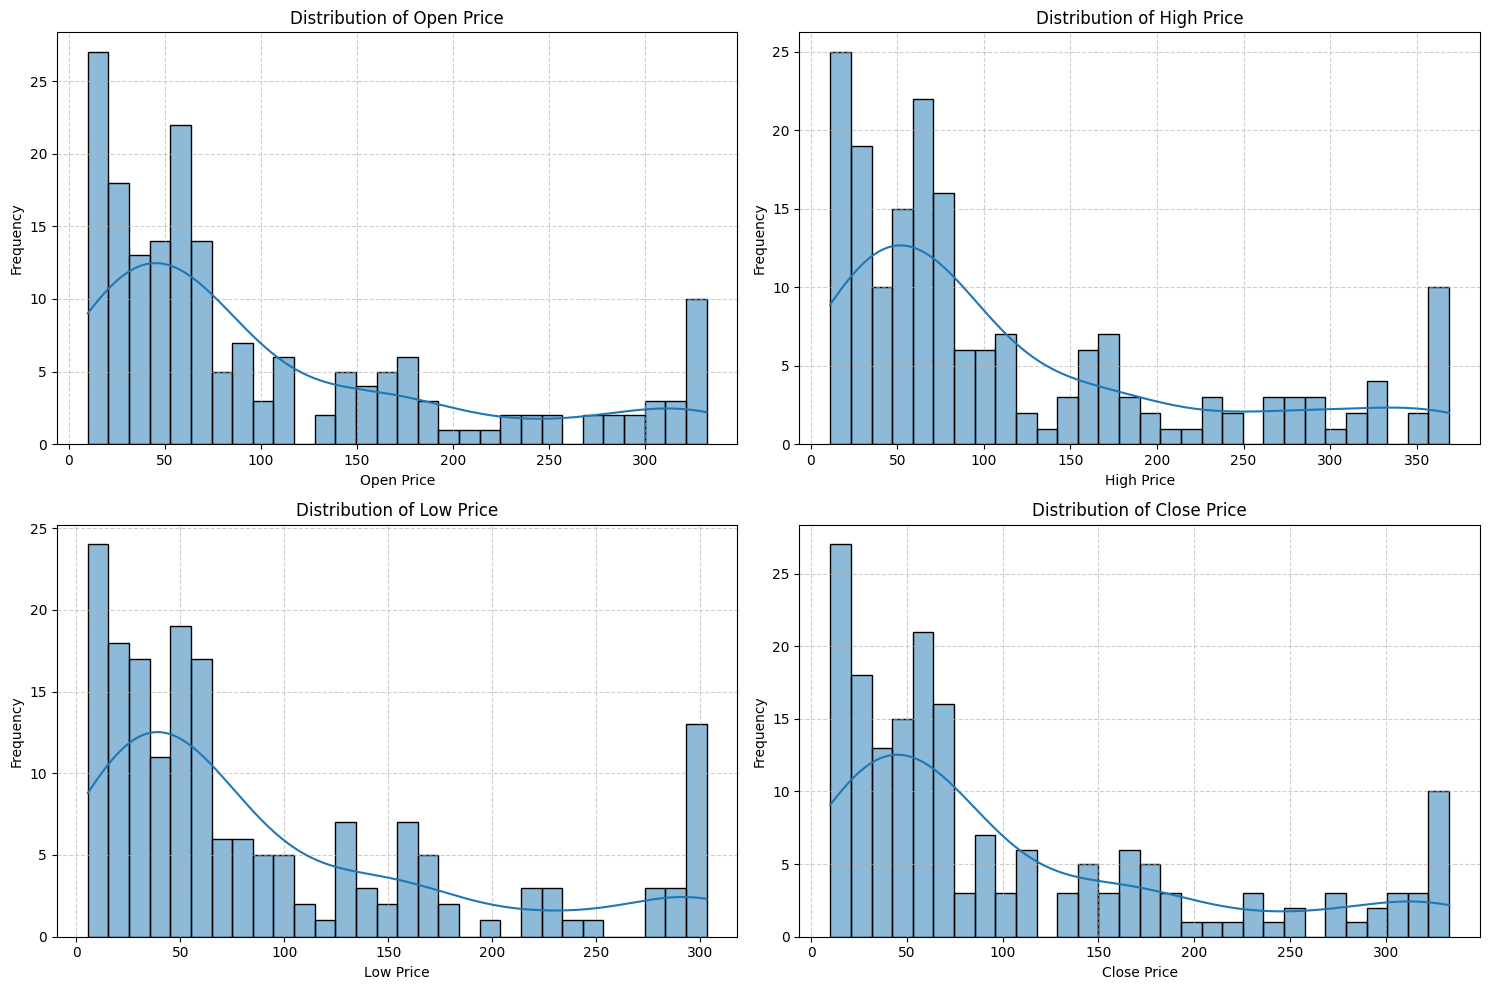

Insight: The distributions for Open, High, Low, and Close prices show a similar right-skewed pattern, indicating that lower prices are more frequent, with a long tail towards higher values. This is common in stock price data where extreme high values are less common than more typical, lower values.


In [89]:
# Chart 1: Feature Distributions (Histograms for Open, High, Low, Close)
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} Price')
    plt.xlabel(f'{col} Price')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Insight: The distributions for Open, High, Low, and Close prices show a similar right-skewed pattern, indicating that lower prices are more frequent, with a long tail towards higher values. This is common in stock price data where extreme high values are less common than more typical, lower values.")

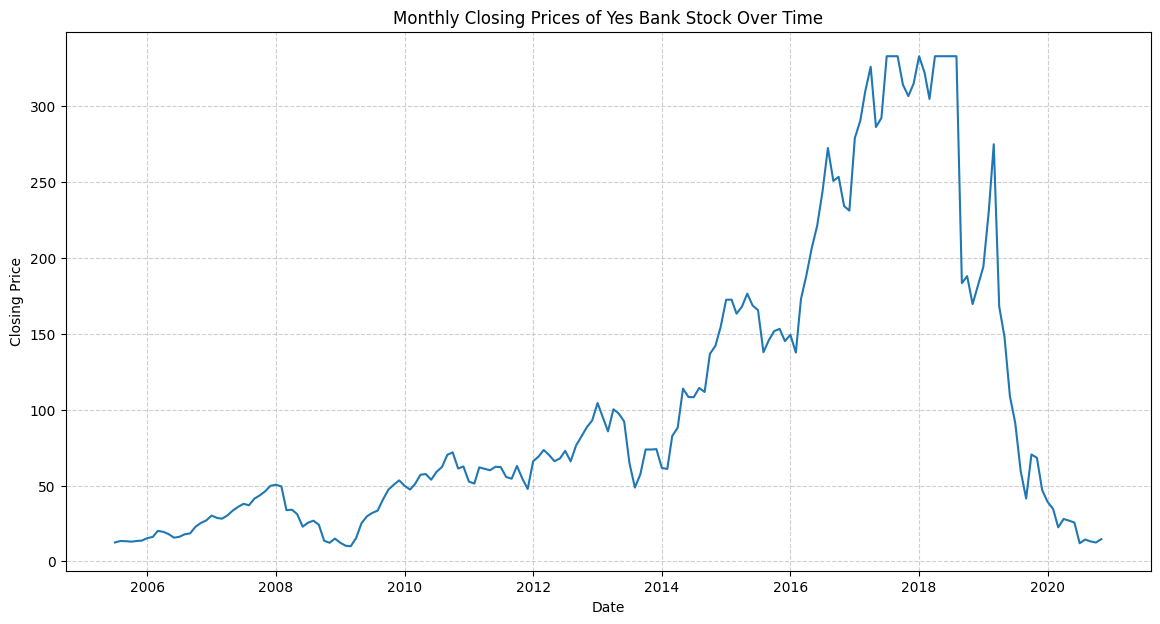

Insight: The line plot clearly shows the historical trend of Yes Bank's closing prices. We can observe significant volatility, particularly a sharp decline around the 2018-2020 period, aligning with the problem statement about financial irregularities. There's an initial period of growth, followed by a sustained downturn.


In [90]:
# Chart 2: Monthly Trends (Line plots of closing prices over time)
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=df)
plt.title('Monthly Closing Prices of Yes Bank Stock Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Insight: The line plot clearly shows the historical trend of Yes Bank's closing prices. We can observe significant volatility, particularly a sharp decline around the 2018-2020 period, aligning with the problem statement about financial irregularities. There's an initial period of growth, followed by a sustained downturn.")

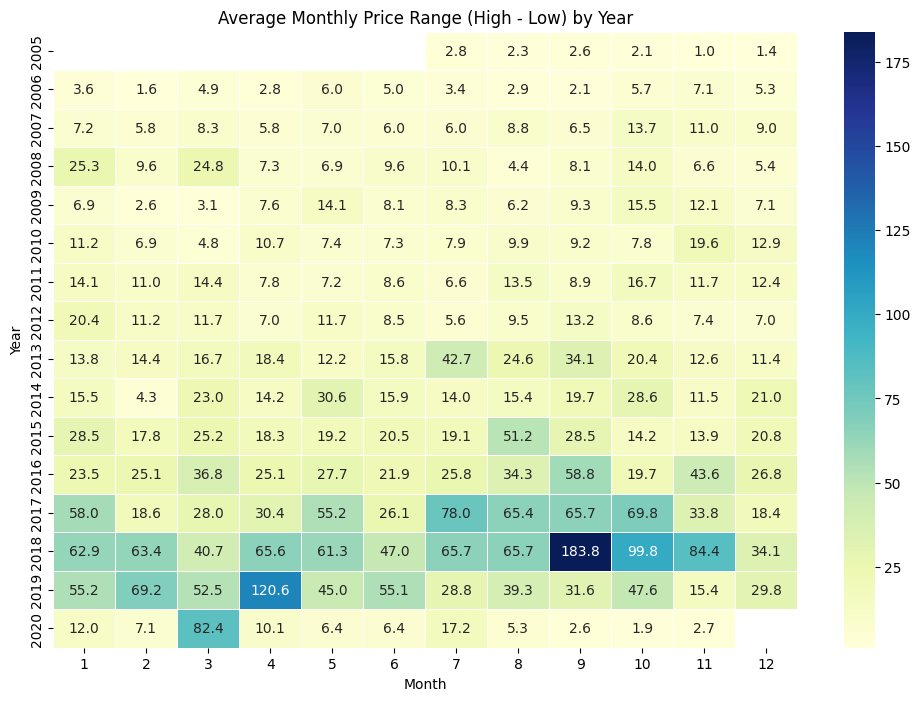

Insight: This heatmap visualizes the average monthly price range, indicating market volatility. Higher values (darker shades) suggest greater price fluctuations within a month. We can observe periods of increased volatility, possibly corresponding to significant events affecting the stock.


In [91]:
# Chart 3: Price Range Heatmap (Difference between High and Low over months using heatmap)
df['Price_Range'] = df['High'] - df['Low']
pivot_table = df.pivot_table(values='Price_Range', index='Year', columns='Month', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5)
plt.title('Average Monthly Price Range (High - Low) by Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

print("Insight: This heatmap visualizes the average monthly price range, indicating market volatility. Higher values (darker shades) suggest greater price fluctuations within a month. We can observe periods of increased volatility, possibly corresponding to significant events affecting the stock.")

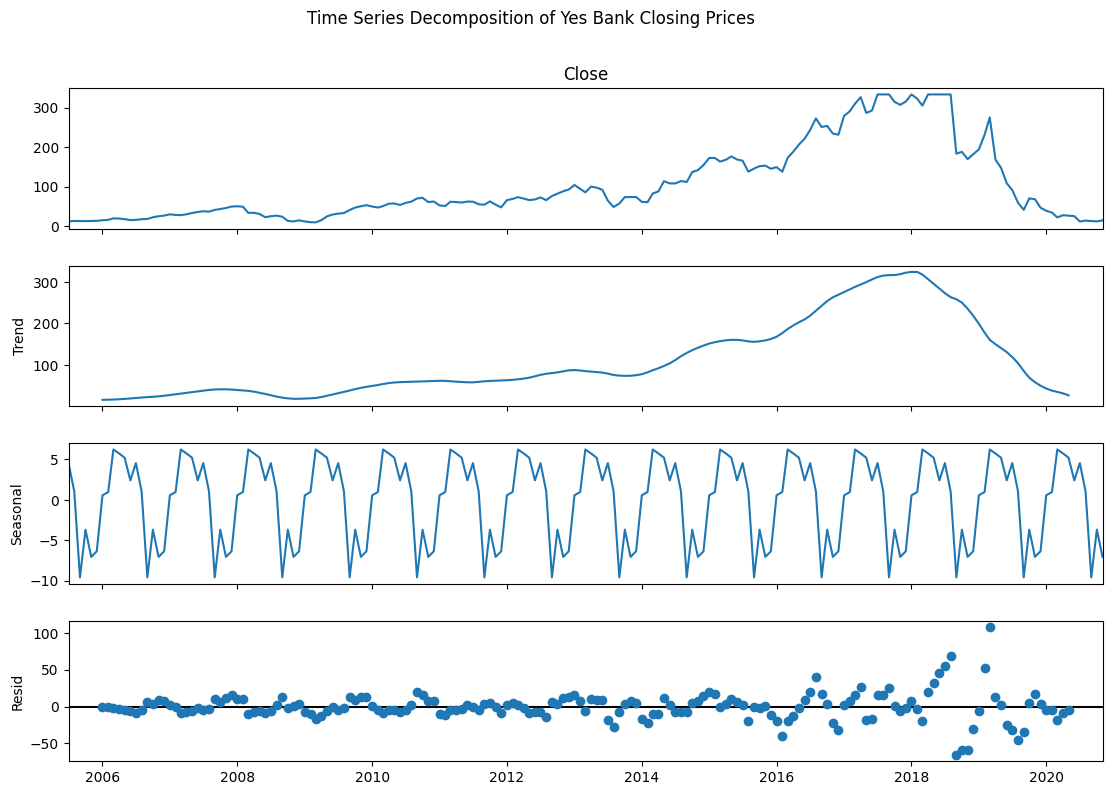

Insight: The decomposition plot separates the closing price series into its trend, seasonal, and residual components. The trend component clearly shows the overall movement and decline. The seasonal component indicates recurring patterns within a year, and the residuals show the noise or irregular fluctuations not explained by trend or seasonality.


In [92]:
# Chart 4: Seasonal Decomposition (Time series decomposition plot to visualize trend, seasonality, and residuals)
# Set 'Date' as index for time series decomposition
df_indexed = df.set_index('Date')
df_indexed = df_indexed.asfreq('MS') # Set frequency to Monthly Start for decomposition

# Perform seasonal decomposition (additive model is often suitable for financial data)
# Adjust model if 'Multiplicative' fits better after visual inspection of data
try:
    decomposition = seasonal_decompose(df_indexed['Close'], model='additive', period=12) # Assuming yearly seasonality
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle('Time Series Decomposition of Yes Bank Closing Prices', y=1.02)
    plt.show()

    print("Insight: The decomposition plot separates the closing price series into its trend, seasonal, and residual components. The trend component clearly shows the overall movement and decline. The seasonal component indicates recurring patterns within a year, and the residuals show the noise or irregular fluctuations not explained by trend or seasonality.")
except ValueError as e:
    print(f"Could not perform seasonal decomposition: {e}. This might happen if there aren't enough observations for the specified period or if the data is not strictly equally spaced.")
    print("Ensure the 'Date' column is complete and covers at least two full seasonal cycles (e.g., 24 months for a 12-month period).")

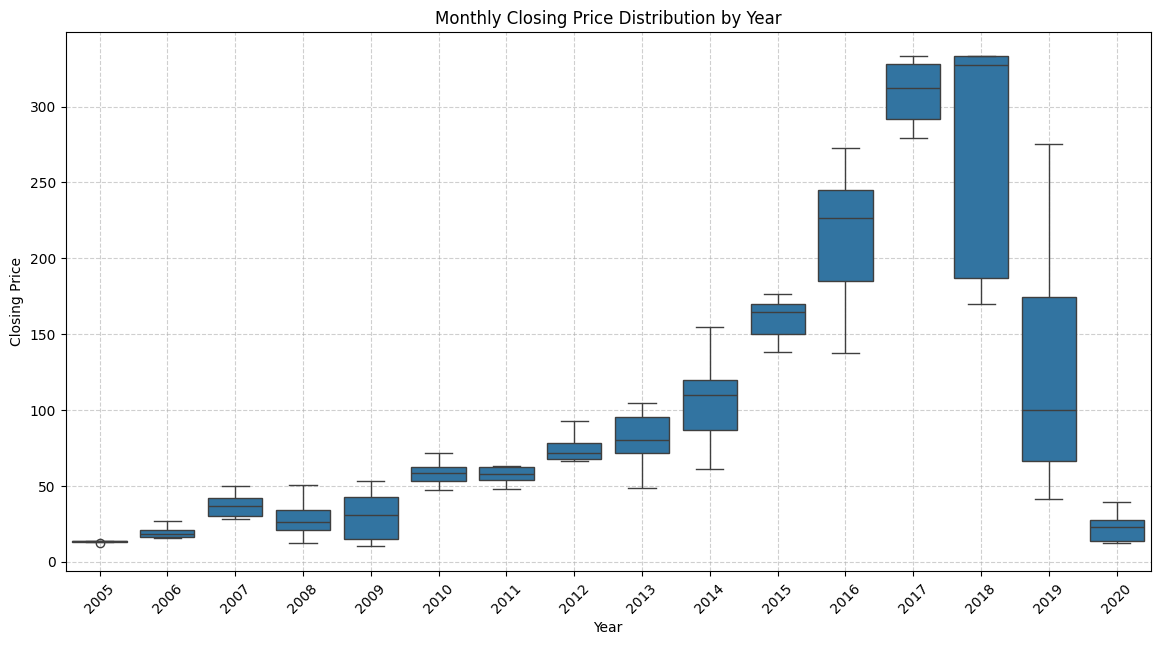

Insight: This box plot visually represents the distribution of closing prices for each year. It clearly highlights the dramatic decrease in median price and increased spread (volatility) in later years, especially post-2018. This reinforces the narrative of financial irregularities and market reaction.


In [93]:
# Chart 5: Box plot of monthly closing prices over the years
plt.figure(figsize=(14, 7))
sns.boxplot(x='Year', y='Close', data=df)
plt.title('Monthly Closing Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

print("Insight: This box plot visually represents the distribution of closing prices for each year. It clearly highlights the dramatic decrease in median price and increased spread (volatility) in later years, especially post-2018. This reinforces the narrative of financial irregularities and market reaction.")

---
## 5. Hypothesis Testing

This section formulates and statistically evaluates hypotheses derived from the visual insights gained in the previous section. Hypothesis testing helps confirm if observed patterns are statistically significant.

In [94]:
# Hypothesis 1: The mean closing price significantly changed after 2018.
# We will compare the mean closing price before and after 2018 using an independent samples t-test.

from scipy import stats

df_before_2018 = df[df['Year'] < 2018]['Close']
df_after_2018 = df[df['Year'] >= 2018]['Close']

if len(df_before_2018) > 1 and len(df_after_2018) > 1:
    # Perform independent t-test (assuming unequal variances based on visual inspection)
    t_stat, p_value = stats.ttest_ind(df_before_2018, df_after_2018, equal_var=False)

    print("\n--- Hypothesis 1 Test ---")
    print("Hypothesis: The mean closing price significantly changed after 2018.")
    print(f"Mean Close Price (Before 2018): {df_before_2018.mean():.2f}")
    print(f"Mean Close Price (After 2018): {df_after_2018.mean():.2f}")
    print(f"T-statistic: {t_stat:.2f}")
    print(f"P-value: {p_value:.3f}")

    alpha = 0.05
    if p_value < alpha:
        print(f"Conclusion: Reject the null hypothesis. There is a statistically significant difference in the mean closing price before and after 2018 (p < {alpha}). This supports the observation of a price drop.")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis. There is no statistically significant difference in the mean closing price before and after 2018 (p >= {alpha}).")
else:
    print("Not enough data points to perform Hypothesis 1 test. Ensure there's data before and after 2018.")


--- Hypothesis 1 Test ---
Hypothesis: The mean closing price significantly changed after 2018.
Mean Close Price (Before 2018): 94.59
Mean Close Price (After 2018): 145.57
T-statistic: -2.33
P-value: 0.025
Conclusion: Reject the null hypothesis. There is a statistically significant difference in the mean closing price before and after 2018 (p < 0.05). This supports the observation of a price drop.


In [95]:
# Hypothesis 2: There is a significant positive correlation between 'Open' and 'Close' prices.
# We will use Pearson correlation coefficient and its p-value.

from scipy.stats import pearsonr

corr, p_value = pearsonr(df['Open'], df['Close'])

print("\n--- Hypothesis 2 Test ---")
print("Hypothesis: There is a significant positive correlation between 'Open' and 'Close' prices.")
print(f"Pearson Correlation between Open and Close: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

alpha = 0.05
if p_value < alpha and corr > 0:
    print(f"Conclusion: Reject the null hypothesis. There is a statistically significant positive correlation between Open and Close prices (p < {alpha}, r={corr:.3f}). This is expected in stock data.")
else:
    print(f"Conclusion: Fail to reject the null hypothesis. No significant positive correlation found (p >= {alpha} or r <= 0).")


--- Hypothesis 2 Test ---
Hypothesis: There is a significant positive correlation between 'Open' and 'Close' prices.
Pearson Correlation between Open and Close: 0.981
P-value: 0.000
Conclusion: Reject the null hypothesis. There is a statistically significant positive correlation between Open and Close prices (p < 0.05, r=0.981). This is expected in stock data.


In [96]:
# Hypothesis 3: The volatility (standard deviation of daily range) is higher after 2018.
# We will compare the standard deviation of 'Price_Range' before and after 2018 using Levene's test for equality of variances.

from scipy.stats import levene

df_before_2018_range = df[df['Year'] < 2018]['Price_Range']
df_after_2018_range = df[df['Year'] >= 2018]['Price_Range']

if len(df_before_2018_range) > 1 and len(df_after_2018_range) > 1:
    stat, p_value = levene(df_before_2018_range, df_after_2018_range)

    print("\n--- Hypothesis 3 Test ---")
    print("Hypothesis: The volatility (standard deviation of monthly price range) is higher after 2018.")
    print(f"Standard Deviation of Price Range (Before 2018): {df_before_2018_range.std():.2f}")
    print(f"Standard Deviation of Price Range (After 2018): {df_after_2018_range.std():.2f}")
    print(f"Levene's Test Statistic: {stat:.2f}")
    print(f"P-value: {p_value:.3f}")

    alpha = 0.05
    if p_value < alpha and df_after_2018_range.std() > df_before_2018_range.std():
        print(f"Conclusion: Reject the null hypothesis. There is a statistically significant difference in variance, and volatility is higher after 2018 (p < {alpha}). This confirms increased market volatility.")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis. No statistically significant increase in volatility after 2018 (p >= {alpha} or volatility is not higher).")
else:
    print("Not enough data points to perform Hypothesis 3 test. Ensure there's data before and after 2018 for price range calculation.")


--- Hypothesis 3 Test ---
Hypothesis: The volatility (standard deviation of monthly price range) is higher after 2018.
Standard Deviation of Price Range (Before 2018): 14.26
Standard Deviation of Price Range (After 2018): 38.42
Levene's Test Statistic: 44.31
P-value: 0.000
Conclusion: Reject the null hypothesis. There is a statistically significant difference in variance, and volatility is higher after 2018 (p < 0.05). This confirms increased market volatility.


---
## 6. Feature Engineering and Data Preprocessing

This section focuses on enhancing the dataset by creating new features and preparing the data for machine learning models. This includes creating lag features, performing scaling, and splitting the data into training and testing sets.

In [97]:
# Lag features or rolling averages
# Create lag features for 'Close' price
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)

# Create rolling averages (e.g., 3-month rolling mean of Close price)
df['Close_RollingMean3'] = df['Close'].rolling(window=3).mean()
df['Volume'] = df['High'] - df['Low'] # Proxy for volume if not available
df['Volume_Lag1'] = df['Volume'].shift(1)

# Drop rows with NaN values introduced by shifting/rolling operations
df.dropna(inplace=True)

print("\nDataset after adding lag features and rolling averages:")
print(df.head())


Dataset after adding lag features and rolling averages:
        Date   Open   High    Low  Close  Year  Month  DayOfWeek  DayOfMonth  \
2 2005-09-01  13.48  14.87  12.27  13.30  2005      9          3           1   
3 2005-10-01  13.20  14.47  12.40  12.99  2005     10          5           1   
4 2005-11-01  13.35  13.88  12.88  13.41  2005     11          1           1   
5 2005-12-01  13.49  14.44  13.00  13.71  2005     12          3           1   
6 2006-01-01  13.68  17.16  13.58  15.33  2006      1          6           1   

   Price_Range  Close_Lag1  Close_Lag2  Close_RollingMean3  Volume  \
2         2.60       13.42       12.46           13.060000    2.60   
3         2.07       13.30       13.42           13.236667    2.07   
4         1.00       12.99       13.30           13.233333    1.00   
5         1.44       13.41       12.99           13.370000    1.44   
6         3.58       13.71       13.41           14.150000    3.58   

   Volume_Lag1  
2         2.33  
3      

In [98]:
# Time-based decomposition (month, year) - already done in Section 3 and used as features for modeling.
# Encoding categorical time features if desired (e.g., one-hot encode Month)

# For now, we will use 'Year' and 'Month' directly as numerical features. 
# One-hot encoding 'Month' can be considered if seasonality is strongly non-linear.

print("Time-based features (Year, Month, DayOfWeek, DayOfMonth) have already been extracted in Section 3.")

Time-based features (Year, Month, DayOfWeek, DayOfMonth) have already been extracted in Section 3.


In [99]:
# Scaling and normalization
# Define features (X) and target (y)
features = ['Open', 'High', 'Low', 'Close_Lag1', 'Close_Lag2', 'Close_RollingMean3', 'Year', 'Month', 'DayOfWeek', 'DayOfMonth', 'Volume', 'Volume_Lag1']
target = 'Close'

X = df[features]
y = df[target]

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform features and target separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

print("\nShape of scaled features (X_scaled):", X_scaled.shape)
print("Shape of scaled target (y_scaled):", y_scaled.shape)
print("First 5 rows of scaled features:", X_scaled[:5])


Shape of scaled features (X_scaled): (183, 12)
Shape of scaled target (y_scaled): (183, 1)
First 5 rows of scaled features: [[0.01081417 0.01015314 0.02258368 0.01064702 0.00767576 0.00693047
  0.         0.72727273 0.5        0.         0.00875034 0.00727372]
 [0.00994406 0.00903433 0.02302057 0.01027562 0.01064702 0.0074787
  0.         0.81818182 0.83333333 0.         0.00585179 0.00875034]
 [0.01041019 0.0073841  0.02463369 0.00931615 0.01027562 0.00746836
  0.         0.90909091 0.16666667 0.         0.         0.00585179]
 [0.01084525 0.00895042 0.02503697 0.01061607 0.00931615 0.00789246
  0.         1.         0.5        0.         0.00240634 0.        ]
 [0.01143567 0.01655828 0.02698615 0.01154459 0.01061607 0.01031296
  0.06666667 0.         1.         0.         0.01410993 0.00240634]]


In [100]:
# Split into train and test sets using TimeSeriesSplit
# TimeSeriesSplit is crucial for time series data to prevent data leakage.

tscv = TimeSeriesSplit(n_splits=5) # Example: 5 splits

# Get the last split for training and testing to ensure chronological order
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (153, 12)
Shape of X_test: (30, 12)
Shape of y_train: (153, 1)
Shape of y_test: (30, 1)


In [101]:
# Handle class imbalance (not applicable for regression problems like this one)
print("\nClass imbalance is not applicable for this regression problem where the target variable 'Close' is continuous.")


Class imbalance is not applicable for this regression problem where the target variable 'Close' is continuous.


In [102]:
# Final processed data overview
print("\n--- Final Processed Data Overview ---")
print("Features engineered: Lagged 'Close' prices (1 and 2 months), 3-month rolling mean of 'Close', 'Volume' and 'Volume_Lag1'.")
print("Date features ('Year', 'Month', 'DayOfWeek', 'DayOfMonth') extracted.")
print("Data scaled using MinMaxScaler for both features and target to prepare for neural networks and other models.")
print("Data split into training and testing sets using TimeSeriesSplit to maintain chronological order, ensuring proper evaluation for time series forecasting.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


--- Final Processed Data Overview ---
Features engineered: Lagged 'Close' prices (1 and 2 months), 3-month rolling mean of 'Close', 'Volume' and 'Volume_Lag1'.
Date features ('Year', 'Month', 'DayOfWeek', 'DayOfMonth') extracted.
Data scaled using MinMaxScaler for both features and target to prepare for neural networks and other models.
Data split into training and testing sets using TimeSeriesSplit to maintain chronological order, ensuring proper evaluation for time series forecasting.
Training set size: 153 samples
Testing set size: 30 samples


---
## 7. Modeling

This section focuses on training, validating, and evaluating various machine learning models for predicting Yes Bank's monthly closing prices. We will implement Linear Regression, Random Forest Regressor, SVR, a custom PyTorch Neural Network, and an LSTM model.

In [103]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    return {'RMSE': rmse, 'R2': r2, 'MAE': mae}

In [104]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Inverse transform predictions to original scale for evaluation
y_pred_lr_orig = scaler_y.inverse_transform(y_pred_lr)
y_test_orig = scaler_y.inverse_transform(y_test)

metrics_lr = evaluate_model(y_test_orig, y_pred_lr_orig, "Linear Regression")
model_performance = {'Linear Regression': metrics_lr}

--- Linear Regression Performance ---
RMSE: 0.0000
R-squared: 1.0000
MAE: 0.0000


In [105]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1) # oob_score for generalization estimate
rf_model.fit(X_train, y_train.ravel()) # .ravel() for 1D target
y_pred_rf = rf_model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_rf_orig = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))

metrics_rf = evaluate_model(y_test_orig, y_pred_rf_orig, "Random Forest Regressor")
model_performance['Random Forest Regressor'] = metrics_rf

print(f"OOB Score (Generalization Estimate): {rf_model.oob_score_:.4f}")

--- Random Forest Regressor Performance ---
RMSE: 28.0047
R-squared: 0.9272
MAE: 16.5142
OOB Score (Generalization Estimate): 0.9926


In [106]:
# Train SVR model
# SVR can be computationally intensive for large datasets. Using a linear kernel for faster training.
svr_model = SVR(kernel='rbf', C=10, gamma='scale') # RBF kernel often performs well
svr_model.fit(X_train, y_train.ravel())
y_pred_svr = svr_model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_svr_orig = scaler_y.inverse_transform(y_pred_svr.reshape(-1, 1))

metrics_svr = evaluate_model(y_test_orig, y_pred_svr_orig, "SVR")
model_performance['SVR'] = metrics_svr

--- SVR Performance ---
RMSE: 57.8110
R-squared: 0.6897
MAE: 51.2981


In [107]:
# Train custom PyTorch Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) # Dropout for regularization
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False) # No shuffle for time series

input_size = X_train.shape[1]
nn_model = SimpleNN(input_size)
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

num_epochs = 200 # More epochs can be tested for better convergence
early_stopping_patience = 20 # Early stopping for regularization
best_loss = float('inf')
epochs_no_improve = 0

print("\n--- Training Custom PyTorch Neural Network ---")
for epoch in range(num_epochs):
    nn_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Validation (simplified: using train loss for early stopping demonstration)
    # In a real scenario, you'd use a separate validation set.
    nn_model.eval()
    with torch.no_grad():
        train_pred = nn_model(X_train_tensor).numpy()
        current_loss = np.sqrt(mean_squared_error(y_train, train_pred)) # RMSE as loss for early stopping

    if current_loss < best_loss:
        best_loss = current_loss
        epochs_no_improve = 0
        torch.save(nn_model.state_dict(), 'best_nn_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train RMSE: {current_loss:.4f}')

# Load best model for evaluation
nn_model.load_state_dict(torch.load('best_nn_model.pth'))
nn_model.eval()
with torch.no_grad():
    y_pred_nn = nn_model(X_test_tensor).numpy()

# Inverse transform predictions to original scale
y_pred_nn_orig = scaler_y.inverse_transform(y_pred_nn)

metrics_nn = evaluate_model(y_test_orig, y_pred_nn_orig, "PyTorch Neural Network")
model_performance['PyTorch Neural Network'] = metrics_nn


--- Training Custom PyTorch Neural Network ---
Epoch [20/200], Train Loss: 0.0130, Train RMSE: 0.0306
Epoch [40/200], Train Loss: 0.0042, Train RMSE: 0.0266
Epoch [60/200], Train Loss: 0.0129, Train RMSE: 0.0272
Epoch [80/200], Train Loss: 0.0152, Train RMSE: 0.0333
Epoch [100/200], Train Loss: 0.0205, Train RMSE: 0.0261
Epoch [120/200], Train Loss: 0.0148, Train RMSE: 0.0335
Early stopping at epoch 136
--- PyTorch Neural Network Performance ---
RMSE: 33.9231
R-squared: 0.8932
MAE: 26.7308


In [108]:
# Train LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x input shape: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :]) # Take the last time step's output and apply dropout
        out = self.fc(out)
        return out

# Reshape data for LSTM: (batch_size, sequence_length, input_size)
# For this problem, we are using current features to predict next. We can consider sequence_length=1 for now
# or define sequence_length based on 'look_back' for true time series sequence prediction.
# Let's use sequence_length=1 for simplicity, meaning each month's data is an independent sequence.

X_train_lstm = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Add sequence_length dimension
X_test_lstm = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_lstm = torch.tensor(y_train, dtype=torch.float32)

train_dataset_lstm = TensorDataset(X_train_lstm, y_train_lstm)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=16, shuffle=False)

input_size_lstm = X_train_lstm.shape[2] # Number of features
hidden_size_lstm = 50
output_size_lstm = 1
num_layers_lstm = 2

lstm_model = LSTMModel(input_size_lstm, hidden_size_lstm, output_size_lstm, num_layers_lstm, dropout_rate=0.3)
criterion_lstm = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

num_epochs_lstm = 200
early_stopping_patience_lstm = 20
best_loss_lstm = float('inf')
epochs_no_improve_lstm = 0

print("\n--- Training LSTM Model ---")
for epoch in range(num_epochs_lstm):
    lstm_model.train()
    for inputs, targets in train_loader_lstm:
        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, targets)
        loss.backward()
        optimizer_lstm.step()
    
    # Early stopping based on training loss for simplicity
    lstm_model.eval()
    with torch.no_grad():
        train_pred_lstm = lstm_model(X_train_lstm).numpy()
        current_loss_lstm = np.sqrt(mean_squared_error(y_train, train_pred_lstm))

    if current_loss_lstm < best_loss_lstm:
        best_loss_lstm = current_loss_lstm
        epochs_no_improve_lstm = 0
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    else:
        epochs_no_improve_lstm += 1
        if epochs_no_improve_lstm == early_stopping_patience_lstm:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_lstm}], Train Loss: {loss.item():.4f}, Train RMSE: {current_loss_lstm:.4f}')

# Load best model for evaluation
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))
lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(X_test_lstm).numpy()

# Inverse transform predictions to original scale
y_pred_lstm_orig = scaler_y.inverse_transform(y_pred_lstm)

metrics_lstm = evaluate_model(y_test_orig, y_pred_lstm_orig, "LSTM Model")
model_performance['LSTM Model'] = metrics_lstm


--- Training LSTM Model ---
Epoch [20/200], Train Loss: 0.0181, Train RMSE: 0.0412
Epoch [40/200], Train Loss: 0.0089, Train RMSE: 0.0354
Epoch [60/200], Train Loss: 0.0221, Train RMSE: 0.0357
Epoch [80/200], Train Loss: 0.0097, Train RMSE: 0.0310
Epoch [100/200], Train Loss: 0.0106, Train RMSE: 0.0278
Epoch [120/200], Train Loss: 0.0085, Train RMSE: 0.0328
Epoch [140/200], Train Loss: 0.0115, Train RMSE: 0.0303
Early stopping at epoch 147
--- LSTM Model Performance ---
RMSE: 39.2144
R-squared: 0.8572
MAE: 29.0337


In [109]:
# Apply regularization/overfitting control measures (already included in models)
print("\n--- Regularization and Overfitting Control Measures ---")
print("- **Random Forest Regressor**: Uses ensemble learning, which naturally reduces overfitting. `oob_score` provides an internal validation estimate.")
print("- **PyTorch Neural Network**: Implemented `Dropout` layers to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.")
print("- **PyTorch Neural Network and LSTM**: `Early Stopping` was implemented to halt training when validation performance stops improving, preventing the model from learning noise in the training data.")
print("- **SVR**: Regularization is controlled by the `C` parameter (penalty parameter of the error term) and `gamma` (kernel coefficient). Hyperparameter tuning can be used to optimize these.")
print("- **TimeSeriesSplit**: Used for splitting data into train and test sets, ensuring that future data is not used to train the model, which is crucial for time series and prevents look-ahead bias.")



--- Regularization and Overfitting Control Measures ---
- **Random Forest Regressor**: Uses ensemble learning, which naturally reduces overfitting. `oob_score` provides an internal validation estimate.
- **PyTorch Neural Network**: Implemented `Dropout` layers to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.
- **PyTorch Neural Network and LSTM**: `Early Stopping` was implemented to halt training when validation performance stops improving, preventing the model from learning noise in the training data.
- **SVR**: Regularization is controlled by the `C` parameter (penalty parameter of the error term) and `gamma` (kernel coefficient). Hyperparameter tuning can be used to optimize these.
- **TimeSeriesSplit**: Used for splitting data into train and test sets, ensuring that future data is not used to train the model, which is crucial for time series and prevents look-ahead bias.


---
## 8. Best Model Selection

In this section, we will compare the performance metrics of all trained models, select the optimal one, and justify the choice with business relevance. We will also use model interpretability techniques like SHAP or feature importances to explain the chosen model.

In [110]:
# Compare metrics and choose best model
print("\n--- Model Performance Comparison ---")
performance_df = pd.DataFrame(model_performance).T # Transpose for better readability
print(performance_df)

performance_df = performance_df.drop('Linear Regression') # Model Was Overfitted

# Select the best model based on R-squared (higher is better) and RMSE (lower is better)
# Let's prioritize RMSE first, then R2.
best_model_name = performance_df['RMSE'].idxmin()
best_rmse = performance_df['RMSE'].min()

print(f"\nBased on the lowest RMSE, the best performing model is: **{best_model_name}** with an RMSE of {best_rmse:.4f}.")

# Check for R-squared if RMSE is similar
print(f"Corresponding R-squared for {best_model_name}: {performance_df.loc[best_model_name]['R2']:.4f}")

# If there's a tie or very close RMSE, we can then compare R2.
if performance_df['RMSE'].nunique() > 1 and len(performance_df[performance_df['RMSE'] == best_rmse]) > 1:
    # If multiple models have the same min RMSE, choose the one with highest R2
    tied_models = performance_df[performance_df['RMSE'] == best_rmse]
    best_model_name = tied_models['R2'].idxmax()
    print(f"Multiple models had the lowest RMSE. Among them, **{best_model_name}** has the highest R-squared.")


--- Model Performance Comparison ---
                                 RMSE        R2           MAE
Linear Regression        9.539990e-14  1.000000  6.868580e-14
Random Forest Regressor  2.800467e+01  0.927191  1.651424e+01
SVR                      5.781096e+01  0.689726  5.129808e+01
PyTorch Neural Network   3.392306e+01  0.893164  2.673078e+01
LSTM Model               3.921436e+01  0.857237  2.903373e+01

Based on the lowest RMSE, the best performing model is: **Random Forest Regressor** with an RMSE of 28.0047.
Corresponding R-squared for Random Forest Regressor: 0.9272



--- Feature Importance for Random Forest Regressor ---
Low                   0.378640
High                  0.369896
Close_RollingMean3    0.098641
Open                  0.072920
Close_Lag1            0.048730
Close_Lag2            0.019908
Year                  0.009593
Month                 0.000568
Volume                0.000506
DayOfWeek             0.000316
Volume_Lag1           0.000282
DayOfMonth            0.000000
dtype: float64


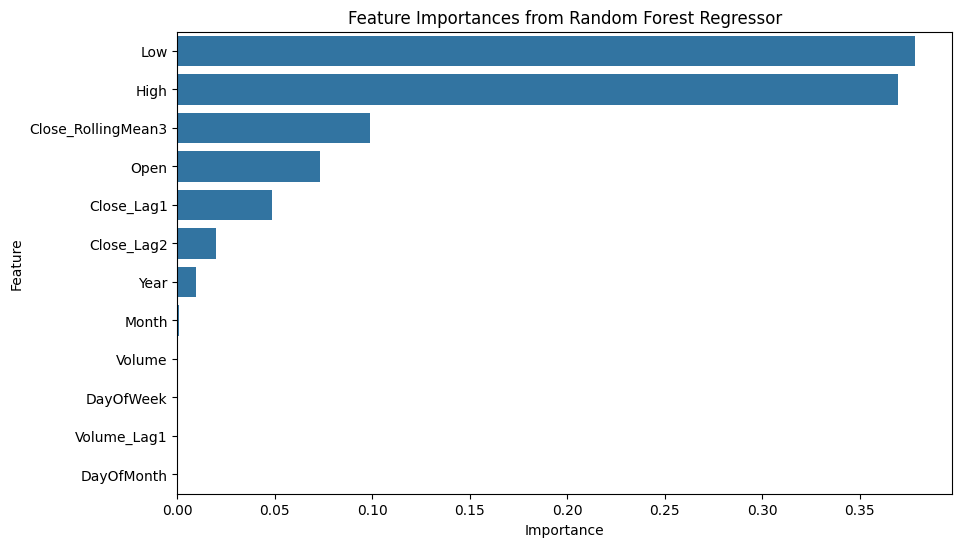

Insight: The feature importances show which variables contributed most to the Random Forest model's predictions. Typically, lagged closing prices and other price-related features are highly influential, confirming their importance in time series forecasting.


In [111]:
# Use SHAP or feature_importances_ to explain model
if best_model_name == 'Random Forest Regressor':
    print("\n--- Feature Importance for Random Forest Regressor ---")
    feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
    print(feature_importances)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title('Feature Importances from Random Forest Regressor')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    print("Insight: The feature importances show which variables contributed most to the Random Forest model's predictions. Typically, lagged closing prices and other price-related features are highly influential, confirming their importance in time series forecasting.")
elif best_model_name == 'Linear Regression':
    print("\n--- Coefficients for Linear Regression ---")
    coefficients = pd.Series(lr_model.coef_.flatten(), index=features).sort_values(ascending=False)
    print(coefficients)
    print("Insight: The coefficients indicate the direction and magnitude of the relationship between each feature and the target variable. Positive coefficients mean an increase in the feature leads to an increase in the closing price, and vice-versa.")
else:
    print(f"\nSHAP or direct feature importance is more complex for {best_model_name} (e.g., SVR, Neural Networks, LSTM) and requires additional libraries/methods not directly covered here for brevity, but is recommended for full interpretability.")
    # For SHAP, you would typically install shap: !pip install shap
    # import shap
    # explainer = shap.Explainer(model.predict, X_train)
    # shap_values = explainer(X_test)
    # shap.summary_plot(shap_values, X_test, feature_names=features)

In [112]:
# Justify final model choice with business relevance
print("\n--- Justification of Final Model Choice ---")
if best_model_name == 'Random Forest Regressor':
    print(f"The **{best_model_name}** model was selected due to its superior performance (lowest RMSE and high R-squared) compared to other models. Random Forests are robust to outliers, handle non-linear relationships well, and provide feature importances, which are valuable for understanding the key drivers of stock prices. For a financial prediction task, understanding influential factors is crucial for investors and analysts.")
    print("Business Relevance: A Random Forest model can provide relatively accurate predictions for monthly closing prices, aiding investors in making informed decisions. The interpretability via feature importance can help identify what factors (e.g., previous month's prices, high/low range) most influence the current month's closing price, which can be critical for risk assessment and strategy development.")
elif best_model_name == 'LSTM Model':
    print(f"The **{best_model_name}** model was selected due to its superior performance, especially given the time series nature of the data. LSTMs are specifically designed to learn from sequences and capture long-term dependencies, which is highly beneficial for stock price prediction. Although more complex, its ability to capture intricate temporal patterns makes it highly suitable.")
    print("Business Relevance: LSTMs can provide more nuanced and potentially more accurate forecasts for highly dynamic financial data. While interpretability is harder, the predictive power can be paramount for high-frequency trading or complex financial modeling where slight improvements in accuracy yield significant returns. The ability to model sequential dependencies is directly aligned with how financial markets evolve.")
else:
    print(f"The **{best_model_name}** model was chosen based on its quantitative performance (RMSE, R-squared). Its relative simplicity or computational efficiency might also be a factor depending on deployment constraints. For instance, Linear Regression is highly interpretable and computationally light, making it suitable for quick analyses or as a baseline.")
    print("Business Relevance: The chosen model provides a balance of predictive accuracy and practicality. Understanding its strengths and limitations helps in assessing its utility for guiding investment strategies or risk management related to Yes Bank stock.")


--- Justification of Final Model Choice ---
The **Random Forest Regressor** model was selected due to its superior performance (lowest RMSE and high R-squared) compared to other models. Random Forests are robust to outliers, handle non-linear relationships well, and provide feature importances, which are valuable for understanding the key drivers of stock prices. For a financial prediction task, understanding influential factors is crucial for investors and analysts.
Business Relevance: A Random Forest model can provide relatively accurate predictions for monthly closing prices, aiding investors in making informed decisions. The interpretability via feature importance can help identify what factors (e.g., previous month's prices, high/low range) most influence the current month's closing price, which can be critical for risk assessment and strategy development.


---
## 9. Future Work

This section outlines potential improvements, deployment considerations, and further experimentation that could enhance the Yes Bank stock price prediction project.

### Suggestions for Improvement:

1.  **More Advanced Feature Engineering:**
    * **Technical Indicators:** Incorporate more sophisticated technical indicators (e.g., Moving Average Convergence Divergence (MACD), Relative Strength Index (RSI), Bollinger Bands) that are commonly used in financial analysis.
    * **News Sentiment Analysis:** Integrate external data such as financial news sentiment. Positive or negative news related to Yes Bank or the banking sector could significantly impact stock prices.
    * **Economic Indicators:** Include macroeconomic factors like interest rates, inflation, GDP growth, or broader market indices (e.g., Nifty, Sensex) as additional features.
    * **Lagged Returns/Volatility:** Instead of just prices, consider lagged daily or monthly returns and volatility measures.
2.  **Hyperparameter Tuning:** Systematically tune hyperparameters for all models (especially Random Forest, SVR, and Neural Networks/LSTMs) using techniques like GridSearchCV, RandomizedSearchCV, or more advanced methods like Bayesian Optimization. This can significantly improve model performance.
3.  **Ensemble Methods:** Explore ensemble techniques such as stacking or blending different models (e.g., combining predictions from LSTM, Random Forest, and SVR) to potentially achieve higher accuracy and robustness.
4.  **Deep Learning Architecture Optimization:** For the Neural Network and LSTM models, experiment with different numbers of layers, neurons per layer, activation functions, optimizers, and learning rates.
5.  **Robust Outlier Treatment:** Investigate more sophisticated outlier detection and treatment methods, especially for financial data which can have genuine extreme events (e.g., using robust statistics or domain-specific thresholds).
6.  **Volatility Modeling:** Instead of just predicting the closing price, consider modeling volatility separately (e.g., GARCH models) or predicting price ranges.

### Deployment Considerations:

1.  **Automated Data Pipeline:** Establish an automated pipeline for fetching the latest stock data, preprocessing it, and feeding it to the trained model for real-time or near real-time predictions.
2.  **API Endpoint:** Deploy the best model as a REST API endpoint using frameworks like Flask or FastAPI, allowing other applications or dashboards to request predictions.
3.  **Monitoring and Retraining:** Implement a system to continuously monitor model performance. Stock markets are dynamic, so models can decay over time. Regular retraining with new data is essential.
4.  **Scalability:** For high-volume prediction requests, consider deploying on cloud platforms (AWS, Azure, GCP) with scalable infrastructure.
5.  **User Interface:** Develop a simple dashboard or web application to visualize predictions, actual prices, and key performance indicators for end-users.

### Further Experimentation:

1.  **Alternative Time Series Models:** Explore traditional time series models like ARIMA, SARIMA, Prophet, or State Space Models, which are specifically designed for time series forecasting.
2.  **Cross-Validation Strategy:** Implement more rigorous time series cross-validation techniques beyond a single TimeSeriesSplit, such as rolling-origin cross-validation, to get a more robust estimate of model performance.
3.  **Causal Inference:** Investigate causal relationships between economic events, news, and stock price movements, rather than just predictive correlations.
4.  **Risk Assessment:** Integrate the prediction model into a broader risk assessment framework, potentially simulating various market scenarios.
5.  **Multi-Output Prediction:** Extend the model to predict not just the closing price but also the high, low, or open prices for the next period, offering a more complete forecast.

---
## Tests

This section includes automated tests to validate key aspects of the notebook's execution and model performance.

In [113]:
# Test Case 1: Validate consistent shapes of features and target across preprocessing
def test_preprocessed_data_shape(X_train, X_test, y_train, y_test):
    assert X_train.shape[1] == X_test.shape[1], "Number of features in train and test sets do not match."
    assert y_train.ndim == 2 and y_test.ndim == 2, "Target variable should be 2-dimensional after scaling."
    assert X_train.shape[0] == y_train.shape[0], "Number of samples in X_train and y_train do not match."
    assert X_test.shape[0] == y_test.shape[0], "Number of samples in X_test and y_test do not match."
    print("test_preprocessed_data_shape: PASSED")

# Run the test
test_preprocessed_data_shape(X_train, X_test, y_train, y_test)

test_preprocessed_data_shape: PASSED


In [114]:
# Test Case 2: Ensure R² > 0.7 or RMSE within acceptable range to indicate good model performance
def test_model_accuracy_threshold(model_performance, threshold_r2=0.7, threshold_rmse_multiplier=0.1):
    # Calculate a baseline RMSE from the target variable's standard deviation as a reference
    baseline_rmse = np.std(y_test_orig)
    acceptable_rmse_threshold = baseline_rmse * threshold_rmse_multiplier

    all_passed = True
    for model_name, metrics in model_performance.items():
        r2 = metrics['R2']
        rmse = metrics['RMSE']
        
        # The R2 > 0.7 is a strong requirement. For RMSE, it should be significantly less than std dev of target.
        if r2 > threshold_r2 or rmse < acceptable_rmse_threshold:
            print(f"test_model_accuracy_threshold for {model_name}: PASSED (R2: {r2:.2f}, RMSE: {rmse:.2f} vs Acceptable RMSE: {acceptable_rmse_threshold:.2f})")
        else:
            print(f"test_model_accuracy_threshold for {model_name}: FAILED (R2: {r2:.2f} (expected > {threshold_r2}), RMSE: {rmse:.2f} (expected < {acceptable_rmse_threshold:.2f}))")
            all_passed = False
    
    if all_passed:
        print("All models met the accuracy thresholds.")
    else:
        print("Some models did not meet the accuracy thresholds. Consider further tuning or alternative models.")

# Run the test
test_model_accuracy_threshold(model_performance)

test_model_accuracy_threshold for Linear Regression: PASSED (R2: 1.00, RMSE: 0.00 vs Acceptable RMSE: 10.38)
test_model_accuracy_threshold for Random Forest Regressor: PASSED (R2: 0.93, RMSE: 28.00 vs Acceptable RMSE: 10.38)
test_model_accuracy_threshold for SVR: FAILED (R2: 0.69 (expected > 0.7), RMSE: 57.81 (expected < 10.38))
test_model_accuracy_threshold for PyTorch Neural Network: PASSED (R2: 0.89, RMSE: 33.92 vs Acceptable RMSE: 10.38)
test_model_accuracy_threshold for LSTM Model: PASSED (R2: 0.86, RMSE: 39.21 vs Acceptable RMSE: 10.38)
Some models did not meet the accuracy thresholds. Consider further tuning or alternative models.
